In [1]:
import json
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, GRU, LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import itertools
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys, os
import traceback
from itertools import chain
import numpy as np
import pandas as pd

import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
def get_sentences(data_list):
    sentences = []
    for a in data_list.article.unique():
        words = []
        prev_n = 0
        for _,s in data_list.loc[data_list.article == a].iterrows():
            n = s['sentence_no']
            if n != prev_n:
                if len(words) > 2 and len(set([x[1] for x in words])) > 1:
                    sentences.append(words)
                words = []
            words.append((s['word'], s['encoding'], s['part_of_speech']))
            prev_n = n
            
        if len(words) > 2 and len(set([x[1] for x in words])) > 1:
            sentences.append(words)
            
    return sentences

In [2]:
def read_data(rootdir):
    data_list = []
    for subdir, dirs, files in os.walk(rootdir):
        for fname in files:
            #print os.path.join(subdir, file)
            filepath = subdir + os.sep + fname
            print(filepath)
            with open(filepath) as f:
                all_lines = f.readlines()
                print(len(all_lines))
                for line1,line2 in zip(all_lines[::2], all_lines[1::2]):
#                     try:
                    text = ast.literal_eval(line1)
                    label = ast.literal_eval(line2)

#                         for i in range(len(label)):
#                             if label[i] == 'NA':
#                                 label[i] = 'O'
                    n_labels = set(label)
                    if len(text) > 3 and len(n_labels) > 1:
                        
                        sentence = [(a,b) for a,b in zip(text, label)]
                        sentence.append(('.', 'O'))
                        sentence = [item for item in sentence if item[0].strip() != '']
                        data_list.append(sentence)
#                     except Exception:
#                         pass
            f.close()
    print(len(data_list))
    return data_list

In [5]:
data_list = read_data('Go_Deep/data/')

print(data_list[0])

print(len(data_list))

words = list(set(y[0] for x in data_list for y in x))
words.append("ENDPAD")
n_words = len(words)
print(n_words)

tags = list(set(y[1] for x in data_list for y in x))
n_tags = len(tags)
print(n_tags)

Go_Deep/data//merged_file.txt
38114
9571
[('A', 'O'), ('Hybrid', 'O'), ('Photoreceptor', 'O'), ('Expressing', 'GO:0010467'), ('Both', 'O'), ('Rod', 'O'), ('and', 'O'), ('Cone', 'O'), ('Genes', 'O'), ('in', 'O'), ('a', 'O'), ('Mouse', 'O'), ('Model', 'O'), ('of', 'O'), ('Enhanced', 'O'), ('SCone', 'O'), ('Syndrome', 'O'), ('.', 'O')]
9571
17921
359


In [3]:
data_list = pd.read_csv('../data/go/go_cc3.csv')
data_list.word.fillna('NA', inplace=True)

temp = pd.read_csv('../data/go/go_bp3.csv')
temp.word.fillna('NA', inplace=True)

temp1 = pd.read_csv('../data/go/go_mf3.csv')
temp1.word.fillna('NA', inplace=True)
temp1 = temp1.rename(columns={'encoding' : 'encoding_z'})

data_list = data_list.merge(temp, on=['article', 'sentence_no', 'word_no'])
data_list = data_list.merge(temp1, on=['article', 'sentence_no', 'word_no'])
data_list.sort_values(['article', 'sentence_no'], kind='mergesort', inplace=True)
x_counts = data_list.encoding_x.value_counts()
y_counts = data_list.encoding_y.value_counts()
z_counts = data_list.encoding_z.value_counts()
# data_list['encoding_x'] = data_list.encoding_x.apply(lambda x: x if x_counts[x] > 4 else 'O')
# data_list['encoding_y'] = data_list.encoding_y.apply(lambda x: x if y_counts[x] > 4 else 'O')
# data_list['encoding'] = [i if (i == 'O' and j == 'O') else j for i,j in zip(data_list.encoding_x, data_list.encoding_y)]
temp_encoding = []
for i,j,k in zip(data_list.encoding_x, data_list.encoding_y, data_list.encoding_z):
    if i == j and j == k:
        temp_encoding.append('O')
    elif i == 'O' and j != 'O':
        temp_encoding.append(j)
    elif j == 'O' and i != 'O':
        temp_encoding.append(i)
    else:
        temp_encoding.append(k)
data_list['encoding'] = temp_encoding
val_cnt = data_list.encoding.value_counts()
data_list['encoding'] = data_list.encoding.apply(lambda x: 'O' if val_cnt[x] < 5 else x)
# data_list = data_list.rename(columns={'word_x' : 'word'})

In [4]:
data_list = get_sentences(data_list)
print(data_list[0])
print(len(data_list))

words = list(set(y[0] for x in data_list for y in x))
n_words = len(words)
print(n_words)

tags = list(set(y[1] for x in data_list for y in x))
n_tags = len(tags)
print(n_tags)

poss = list(set(y[2] for x in data_list for y in x))
n_poss = len(poss)
print(n_poss)

[('Gender', 'O', 'NN'), ('does', 'O', 'VBZ'), ('not', 'O', 'RB'), ('typically', 'O', 'RB'), ('affect', 'O', 'JJ'), ('IOP', 'O', 'NNP'), ('and', 'O', 'CC'), ('aging', 'GO:0007568', 'VBG'), ('results', 'O', 'NNS'), ('in', 'O', 'IN'), ('an', 'O', 'DT'), ('IOP', 'O', 'NNP'), ('decrease', 'O', 'NN'), ('in', 'O', 'IN'), ('some', 'O', 'DT'), ('strains', 'O', 'NNS'), ('.', 'O', '.')]
7579
15979
495
44


In [32]:
max_len = 75
max_len_char = 15

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["O"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["O"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

# pos2idx = {w: i+1 for i, w in enumerate(poss)}
# pos2idx["X"] = 0
# idx2pos = {i: w for w, i in pos2idx.items()}

In [6]:
print(tag2idx)

{'GO:0043005': 1, 'GO:0005813': 253, '2_GO:0010467': 3, '2_GO:0001774': 252, '2_GO:0000806': 254, '2_GO:0006342': 207, '1_GO:0008355': 4, '2_GO:0000795': 256, 'GO:0030286': 257, 'GO:0071514': 2, 'GO:0032391': 5, '3_GO:0006302': 258, '1_GO:0009887': 6, 'GO:0031012': 171, '2_GO:0005770': 455, '1_GO:0007179': 7, '1_GO:0000806': 261, 'GO:0045333': 262, '3_GO:0019395': 300, 'GO:0000786': 35, 'GO:0051325': 8, 'GO:0097617': 463, '1_GO:0010629': 264, '1_GO:0038179': 265, 'GO:0005576': 417, '2_GO:0001764': 395, 'O': 0, '1_GO:0001755': 266, '1_GO:0008283': 10, '1_GO:0060216': 11, 'GO:0016246': 267, '1_GO:0097009': 174, '2_GO:0000380': 269, '3_GO:0032508': 84, 'GO:0045177': 12, 'GO:0097373': 271, '2_GO:0030154': 79, 'GO:0016540': 255, 'GO:0030849': 272, 'GO:0000237': 14, '1_GO:0051216': 273, 'GO:0051235': 274, '1_GO:0006695': 293, '2_GO:0005911': 15, 'GO:0045120': 16, '1_GO:0016605': 17, 'GO:0005739': 435, '1_GO:0001775': 277, '1_GO:0001917': 278, '1_GO:0016055': 380, '1_GO:0006260': 18, 'GO:0006

In [7]:
print(pos2idx)

{'JJS': 1, 'VBN': 20, 'VBP': 2, 'X': 0, 'RBS': 3, ',': 4, 'DT': 5, 'NNPS': 6, 'WRB': 29, '$': 8, 'PDT': 9, '``': 13, '(': 10, 'VBZ': 12, 'RBR': 15, 'VBG': 37, 'SYM': 26, ':': 16, 'RB': 39, 'UH': 17, 'RP': 18, 'POS': 19, 'CD': 21, '.': 7, 'CC': 22, 'JJ': 23, 'JJR': 24, 'TO': 27, "''": 11, 'MD': 28, ')': 30, 'NN': 31, 'VB': 32, 'NNS': 33, '#': 34, 'WP': 25, 'IN': 14, 'FW': 35, 'WDT': 44, 'VBD': 38, 'WP$': 42, 'PRP': 41, 'NNP': 43, 'PRP$': 40, 'EX': 36}


In [7]:
X_word = [[w[0] for w in s] for s in data_list]
new_X = []
for seq in X_word:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("ENDPAD")
    new_X.append(new_seq)
X_word = new_X

In [8]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

104


In [9]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["O"] = 0

In [10]:
X_char = []
for sentence in data_list:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("O"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))


In [39]:
cnts = pd.Series([w[1] for s in data_list for w in s]).value_counts()

In [41]:
y = [[tag2idx[w[1]] if cnts[w[1]] > 10 else 0 for w in s] for s in data_list]
y = pad_sequences(maxlen=max_len, sequences=y,value=tag2idx["O"], padding='post', truncating='post')

In [42]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags+1) for i in y]

In [43]:
from sklearn.model_selection import train_test_split
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.3, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.3, random_state=2018)

In [44]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
sess = tf.Session()
K.set_session(sess)
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(32*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

INFO:tensorflow:Initialize variable module_1/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel
INFO:tensorflow:Initialize variable module_1/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel
INFO:tensorflow:Initialize variable module_1/bilm/CNN/W_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_0
INFO:tensorflow:Initialize variable module_1/bilm/CNN/b_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_6
INFO:tensorflow:Initialize variable module_1/bilm/CNN_proj/W_pro

In [45]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D, Flatten
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D, Lambda

# input and embedding for words
word_in = Input(shape=(max_len,), dtype=tf.string)

emb_word = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(word_in)


# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=100,
                           input_length=max_len_char, mask_zero=True))(char_in)


dropout = Dropout(0.3)(emb_char)

char_enc = TimeDistributed(GRU(units=150, return_sequences=False,
                                recurrent_dropout=0.5))(dropout)

# main GRU
x = concatenate([emb_word, char_enc])
main_gru = Bidirectional(GRU(units=200, return_sequences=True,
                             dropout=0.5,
                               recurrent_dropout=0.25))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_gru)

model = Model([word_in, char_in], out)

In [46]:
from keras.optimizers import RMSprop
import keras.backend as K

def customLoss(yTrue,yPred):
    return - K.sum(yTrue * K.log(yPred))

rmsopt = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=rmsopt, loss=customLoss, metrics=['acc'])

In [47]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 75, 15)       0                                            
__________________________________________________________________________________________________
time_distributed_4 (TimeDistrib (None, 75, 15, 100)  10600       input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 75, 15, 100)  0           time_distributed_4[0][0]         
__________________________________________________________________________________________________
lambda_2 (

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='../data/output/graphs/GRU-Elmo.png')

In [48]:
# history = model.fit([X_word_tr,
#                      np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
#                     np.array(y_tr).reshape(len(y_tr), max_len, 1),
#                     batch_size=32, epochs=15, validation_data=([X_word_te,
#                      np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))],
#                     np.array(y_te).reshape(len(y_te), max_len, 1)),
#                     verbose=1)
history = model.fit([X_word_tr[:len(X_word_tr)//32*32],
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))[:len(X_word_tr)//32*32]],
                    np.array(y_tr[:len(X_word_tr)//32*32]),
                    batch_size=32, epochs=20, validation_data=([X_word_te[:len(y_te)//32*32], 
                     np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))[:len(y_te)//32*32]],
                    np.array(y_te[:len(y_te)//32*32])),
                    verbose=1)

Train on 6688 samples, validate on 2848 samples
Epoch 1/20
6688/6688 [==============================] - 111s 17ms/step - loss: 296.2863 - acc: 0.9518 - val_loss: 87.5756 - val_acc: 0.9763
Epoch 2/20
6688/6688 [==============================] - 109s 16ms/step - loss: 77.1754 - acc: 0.9777 - val_loss: 52.6045 - val_acc: 0.9825
Epoch 3/20
6688/6688 [==============================] - 109s 16ms/step - loss: 49.3385 - acc: 0.9833 - val_loss: 40.1319 - val_acc: 0.9863
Epoch 4/20
6688/6688 [==============================] - 109s 16ms/step - loss: 35.7440 - acc: 0.9872 - val_loss: 35.8943 - val_acc: 0.9876
Epoch 5/20
6688/6688 [==============================] - 109s 16ms/step - loss: 27.9839 - acc: 0.9894 - val_loss: 35.6205 - val_acc: 0.9878
Epoch 6/20
6688/6688 [==============================] - 109s 16ms/step - loss: 23.0225 - acc: 0.9909 - val_loss: 32.9509 - val_acc: 0.9885
Epoch 7/20
6688/6688 [==============================] - 109s 16ms/step - loss: 19.2013 - acc: 0.9924 - val_loss: 33.4

In [49]:
hist = pd.DataFrame(history.history)
hist.to_csv('../data/results/performance/GO_GRU-Elmo.tsv', sep='\t')

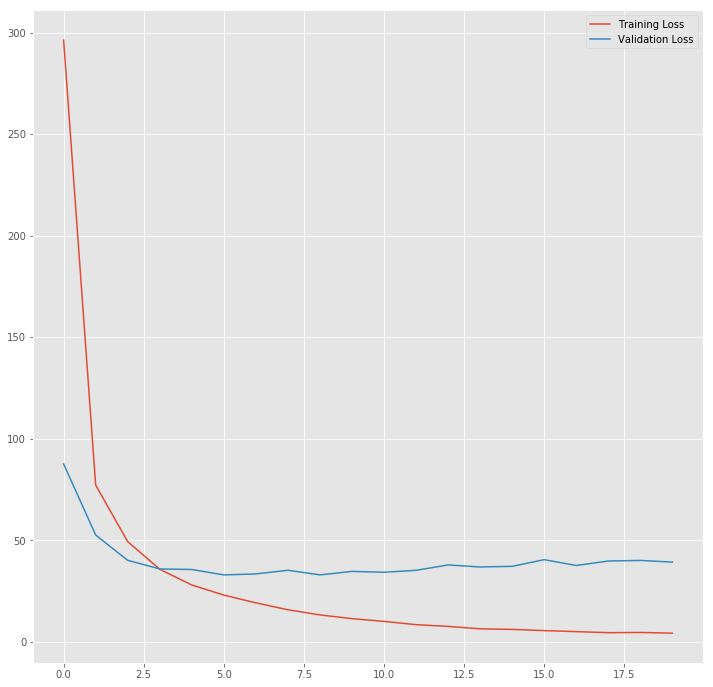

In [50]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"], label='Training Loss')
plt.plot(hist["val_loss"], label='Validation Loss')
plt.legend()
plt.show()

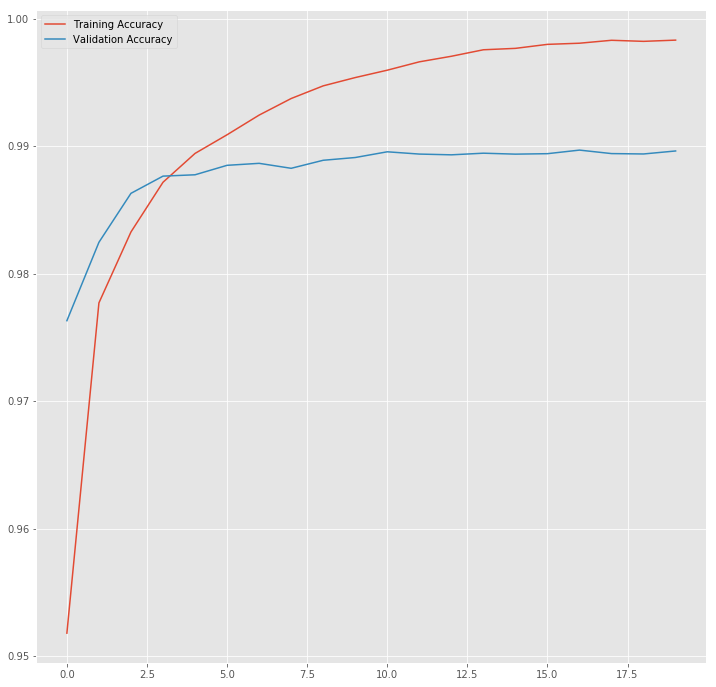

In [51]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"], label='Training Accuracy')
plt.plot(hist["val_acc"], label='Validation Accuracy')
plt.legend()
plt.show()

In [52]:
from sklearn.metrics import classification_report

predicted = model.predict([X_word_te[:len(y_te)//32*32], 
                        np.array(X_char_te[:len(y_te)//32*32]).reshape((len(X_char_te[:len(y_te)//32*32]),
                                                     max_len, max_len_char))])
true = []
predicted_val = []
word = []
for i in range(len(predicted)):
    p_tmp = np.argmax(predicted[i], axis=-1)
    t_tmp = np.argmax(y_te[i], -1)
    word.append(X_word_te[i])
    predicted_val.append(p_tmp)
    true.append(t_tmp)

wd = [list(map(lambda x: y, y)) for y in word]    
p = [list(map(lambda x: idx2tag[x], y)) for y in predicted_val]
t = [list(map(lambda x: idx2tag[x], y)) for y in true]

report = classification_report(list(itertools.chain.from_iterable(t)), 
                                    list(itertools.chain.from_iterable(p)))
# print "\n"
print(report)

                        precision    recall  f1-score   support

            GO:0000003       0.69      0.69      0.69       120
            GO:0000075       1.00      1.00      1.00         8
            GO:0000239       0.88      0.91      0.89        23
            GO:0000240       1.00      1.00      1.00        14
            GO:0000267       0.67      0.80      0.73         5
            GO:0000732       0.79      0.92      0.85        12
            GO:0000775       0.00      0.00      0.00         5
            GO:0000785       0.97      1.00      0.98        28
            GO:0000792       0.96      1.00      0.98        23
            GO:0000805       0.80      1.00      0.89         4
            GO:0001503       1.00      0.90      0.95        10
            GO:0001708       0.00      0.00      0.00         7
            GO:0001763       0.83      0.71      0.77         7
            GO:0001775       0.67      0.77      0.71        13
            GO:0001917       0.00      

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [53]:
i = 300
pred = np.argmax(predicted[i], axis=-1)
print(pred)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, tr, pred in zip(X_word_te[i], np.argmax(y_te[i], -1), pred):
    if w != 0:
        print("{:15}: {:5} {}".format(w, idx2tag[tr], idx2tag[pred]))
        
# pd = model.predict(np.array([X_te[i]]))
# pd = np.argmax(pd, axis=-1)
# true = np.argmax(y_te[i], -1)
# print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
# print(30 * "=")

# for w, t1, pred in zip(X_te[i], true, pd[0]):
#     if w != 0:
#         print("{:15}: {:5} {}".format(words[w-1], tags[t1], tags[pred]))

[  0   0   0   0   0   0   0   0 254   0   0   0   0   0 248   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
Word           ||True ||Pred
These          : O     O
findings       : O     O
suggest        : O     O
that           : O     O
these          : O     O
ESG1like       : O     O
sequences      : O     O
on             : O     O
chromosome     : GO:0005694 GO:0005694
9              : O     O
have           : O     O
not            : O     O
been           : O     O
correctly      : O     O
assembled      : O     GO:0009058
.              : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : 

In [54]:
import pandas as pd

df = pd.DataFrame(
{
    'Predicted' : list(itertools.chain.from_iterable(p)),
    'Ground Truth': list(itertools.chain.from_iterable(t)),
    'Word' : list(itertools.chain.from_iterable(wd)),
}
)


In [55]:
df = df[df['Word'] != 'O']

In [56]:
df1 = df[(df['Predicted'] != 'O') & (df['Ground Truth'] != 'O') | 
         (df['Predicted'] == 'O') & (df['Ground Truth'] != 'O') |
         (df['Predicted'] != 'O') & (df['Ground Truth'] == 'O')
        ]

report = classification_report(df1['Ground Truth'], 
                                    df1['Predicted'])
print("\n")
print(report)



                        precision    recall  f1-score   support

            GO:0000003       0.69      0.69      0.69       120
            GO:0000075       1.00      1.00      1.00         8
            GO:0000239       0.88      0.91      0.89        23
            GO:0000240       1.00      1.00      1.00        14
            GO:0000267       0.67      0.80      0.73         5
            GO:0000732       0.79      0.92      0.85        12
            GO:0000775       0.00      0.00      0.00         5
            GO:0000785       0.97      1.00      0.98        28
            GO:0000792       0.96      1.00      0.98        23
            GO:0000805       0.80      1.00      0.89         4
            GO:0001503       1.00      0.90      0.95        10
            GO:0001708       0.00      0.00      0.00         7
            GO:0001763       0.83      0.71      0.77         7
            GO:0001775       0.67      0.77      0.71        13
            GO:0001917       0.00    

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
